# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблем, предоставляемым библиотекой CatBoost.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from catboost import CatBoostClassifier

### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [130]:
class RandomForestClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", n_estimators=10):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.ensemble = []
        self.mean_error = 0

    def fit(self, X, y):
        n = len(y)
        self.ensemble = [0]*self.n_estimators
        n_error = [0]*self.n_estimators
        for i in range(self.n_estimators):
            X = pd.Series(X)
            y = pd.Series(y)
            index = random.choices([p for p in range(n)], k=n)
            X_0 = X[index]
            y_0 = y[index]
            self.ensemble[i] = DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            self.ensemble[i] = self.ensemble[i].fit(X_0.tolist(), y_0.tolist()) 
            index_another = [p for p in range(n) if p not in index]
            X_another = X[index]
            y_another = y[index]
            n_error.append(self.error(i, X_another.tolist(), y_another.tolist()))
        self.mean_error = np.mean(n_error)
        
        
                    
    def error(self, i, X, y):
        y_pred = []
        for el in X:
            y_pred.append(self.ensemble[i].predict([el]))
        proc = 0
        for i in range(len(y)):
            if y[i] != y_pred[i]:
                proc += 1
        proc /= len(y)
        return proc
            
        
    def predict(self, X):
        y = []
        for el in X:
            sum_ensemble = [0]*3
            for i in range(self.n_estimators):
                pred = int(self.ensemble[i].predict([el]))
                sum_ensemble[pred] += 1
            if sum_ensemble[0] > sum_ensemble[1]:
                if sum_ensemble[0] > sum_ensemble[2]:
                    y.append(0)
                else:
                    y.append(2)
            else:
                if sum_ensemble[1] > sum_ensemble[2]:
                    y.append(1)
                else:
                    y.append(2)
        return y
            
        
        
        
        

### Задание 3 (3 балла)
Оптимизируйте по AUC на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации Random Forest: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте ROC кривую (и выведите AUC и accuracy) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [137]:
data = pd.read_csv('cancer.csv')
data = data.to_numpy()
row = len(data)
X = [0]*row
y = [0]*row
for i in range(row):
    X[i] = data[i][1:]
    if data[i][0] == 'M':
        y[i] = 1
    else:
        y[i] = 0

In [8]:
X_val = [0]*5
y_val = [0]*5
X_train, X_val[0], y_train, y_val[0] = train_test_split(X, y, test_size=0.2)
X_train, X_val[1], y_train, y_val[1] = train_test_split(X_train, y_train, test_size=0.25)
X_train, X_val[2], y_train, y_val[2] = train_test_split(X_train, y_train, test_size=0.333333)
X_val[4], X_val[3], y_val[4], y_val[3] = train_test_split(X_train, y_train, test_size=0.5)


In [18]:
valid(X_val, y_val, 7, 50)
valid(X_val, y_val, 10, 20)
valid(X_val, y_val, 7, 30)
valid(X_val, y_val, 7, 20)
valid(X_val, y_val, 7, 10)
valid(X_val, y_val, 5, 30)
valid(X_val, y_val, 5, 20)
valid(X_val, y_val, 5, 10)
valid(X_val, y_val, 3, 30)

max_depth= 7 n_estimators= 50
[0.9472990777338604, 0.9550618108920813, 0.9439895185063871, 0.9743961352657003, 0.9353846153846155]
0.951226231556529
max_depth= 10 n_estimators= 20
[0.9772727272727273, 0.9809555629802873, 0.932361611529643, 0.948792270531401, 0.9610256410256409]
0.9600815626679399
max_depth= 7 n_estimators= 30
[0.940052700922266, 0.9550618108920813, 0.9580740255486406, 0.9526570048309179, 0.9287179487179487]
0.946912698182371
max_depth= 7 n_estimators= 20
[0.9514163372859025, 0.9672569328433009, 0.9394038650507698, 0.9231884057971015, 0.9415384615384615]
0.9445608005031072
max_depth= 7 n_estimators= 10
[0.9328063241106719, 0.9672569328433009, 0.9510317720275139, 0.9594202898550726, 0.934871794871795]
0.9490774227416707
max_depth= 5 n_estimators= 30
[0.9545454545454545, 0.9619111259605746, 0.9394038650507698, 0.9449275362318841, 0.9153846153846155]
0.9432345194346597
max_depth= 5 n_estimators= 20
[0.9586627140974968, 0.9672569328433009, 0.9394038650507698, 0.941545893719

##### Могу сделать вывод, что лучшими параметрами (если мы хотим хотя бы 0.95) являются max_depth = 5 и n_estimators = 20

Построим для них ROC кривую и выведем AUC и accuracy

Precision, recall, accuracy =  ([0, 0.5964912280701754], [0.0, 1.0], 0.5964912280701754)


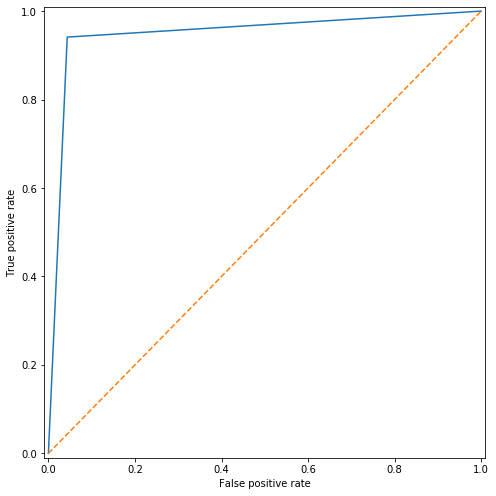

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
tree = RandomForestClassifier(max_depth=5, n_estimators=20)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
predict_proba = []       
for j in range(len(y_pred)):
        if y_pred[j] == 0:
            predict_proba.append({0: 1, 1: 0})
        else:                
            predict_proba.append({0: 0, 1: 1})
print("Precision, recall, accuracy = ", get_precision_recall_accuracy(predict_proba, y_test))
plot_roc_curve(y_test, predict_proba)

In [31]:
def valid(X_val, y_val, max_depth_0, n_estimators_0): 
    print("max_depth=", max_depth_0, "n_estimators=", n_estimators_0)
    tree = RandomForestClassifier(max_depth=max_depth_0, n_estimators=n_estimators_0)

    y_0 = [0]*5
    for i in range(5):
        tree.fit(X_val[i%5] + X_val[(i+1)%5] + X_val[(i+2)%5] + X_val[(i+3)%5], y_val[i%5] + y_val[(i+1)%5] + y_val[(i+2)%5] + y_val[(i+3)%5])
        y_pred = tree.predict(X_val[(i+4)%5])
        predict_proba = []
        for j in range(len(y_pred)):
            if y_pred[j] == 0:
                predict_proba.append({0: 1, 1: 0})
            else:
                predict_proba.append({0: 0, 1: 1})
        tpr, fpr = tpr_fpr(y_val[(i+4)%5], predict_proba)
        y_0[i] = metrics.auc(fpr, tpr)
    print(y_0)
    print(np.mean(y_0))

In [10]:
def tpr_fpr(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    return tpr, fpr

In [11]:
def get_precision_recall_accuracy(y_pred, y_true):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    precision = [0, 0]
    recall = [0, 0]
    for i in range(len(y_pred)):
        if y_pred[i] == 1:
            if y_true[i] == 1:
                TP += 1
            else:
                FP += 1
        else:
            if y_true[i] == 1:
                FN += 1
            else:
                TN += 1
    if TP+FP != 0:
        precision[0] = TP / (TP + FP)
    if TN + FN != 0:
        precision[1] = TN / (TN + FN)
    if TP + FN != 0:
        recall[0] = TP / (TP + FN)
    if TN + FP != 0:
        recall[1] = TN / (TN + FP)
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    
    return precision, recall, accuracy

In [12]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [131]:
def feature_importance(rfc, X, y):
    err_oob = rfc.mean_error
    err_oob_j = []
    n = len(X[0])
    for i in range(n):
        X_0 = np.transpose(X)
        arr = X_0[i]
        random.shuffle(arr)
        X_0[i] = arr
        X_0 = X_0.tolist()
        rfc.fit(np.transpose(X_0).tolist(), y)
        err_oob_j.append(abs(err_oob - rfc.mean_error))
    
    return err_oob_j

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [127]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)


X, y = synthetic_dataset(1000)
for i in range(1000):
    X[i] = np.array(X[i], np.int32)
X = X.tolist()
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
print("Accuracy:", np.mean(rfc.predict(X) == y))

Accuracy: 1.0


In [128]:
print("Importance:", feature_importance(rfc, X, y))

Importance: [0.0, 0.0, 0.079765, 0.079665, 0.139435, 0.0]


Проверьте, какие признаки важны для датасетов cancer и spam?

In [135]:
data = pd.read_csv('cancer.csv')
data = data.to_numpy()
row = len(data)
X = [0]*row
y = [0]*row
for i in range(row):
    X[i] = data[i][1:]
    if data[i][0] == 'M':
        y[i] = 1
    else:
        y[i] = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
print(rfc.predict(X_test))
print(y_test)
print("Accuracy:", np.mean(rfc.predict(X) == y))
print("Importance:", feature_importance(rfc, X, y))

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Accuracy: 0.0
Importance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Странно как-то..

In [ ]:
data = pandas.read_csv('spam.csv')
data = data.to_numpy()
row = len(data)
X = [0]*row
y = [0]*row
for i in range(row):
    X[i] = data[i][:-1]
    y[i] = int(data[i][-1])

### Задание 5 (1 балл)
В качестве аьтернативы попробуем CatBoost. 

Туториалы можно найти, например, [здесь](https://catboost.ai/docs/) и [здесь](https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb).

Также, как и реализованный ними RandomForest, примените его для наших датасетов.

In [133]:
data = pd.read_csv('cancer.csv')
data = data.to_numpy()
row = len(data)
X = [0]*row
y = [0]*row
for i in range(row):
    X[i] = data[i][1:]
    if data[i][0] == 'M':
        y[i] = 1
    else:
        y[i] = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
clf = CatBoostClassifier()
clf.fit(X_train, y_train)
print("Accuracy:", np.mean(clf.predict(X) == y))

Learning rate set to 0.007741
0:	learn: 0.6811499	total: 105ms	remaining: 1m 45s
1:	learn: 0.6684040	total: 121ms	remaining: 1m
2:	learn: 0.6561117	total: 135ms	remaining: 44.9s
3:	learn: 0.6446521	total: 150ms	remaining: 37.2s
4:	learn: 0.6325075	total: 167ms	remaining: 33.1s
5:	learn: 0.6229014	total: 181ms	remaining: 30s
6:	learn: 0.6105545	total: 196ms	remaining: 27.9s
7:	learn: 0.5985803	total: 211ms	remaining: 26.1s
8:	learn: 0.5867703	total: 225ms	remaining: 24.8s
9:	learn: 0.5753751	total: 243ms	remaining: 24.1s
10:	learn: 0.5648451	total: 257ms	remaining: 23.1s
11:	learn: 0.5545033	total: 270ms	remaining: 22.2s
12:	learn: 0.5438788	total: 283ms	remaining: 21.5s
13:	learn: 0.5341227	total: 297ms	remaining: 20.9s
14:	learn: 0.5252119	total: 311ms	remaining: 20.4s
15:	learn: 0.5164958	total: 324ms	remaining: 19.9s
16:	learn: 0.5085794	total: 338ms	remaining: 19.6s
17:	learn: 0.5000845	total: 356ms	remaining: 19.4s
18:	learn: 0.4910532	total: 368ms	remaining: 19s
19:	learn: 0.4823

178:	learn: 0.0844009	total: 1.73s	remaining: 7.93s
179:	learn: 0.0839149	total: 1.74s	remaining: 7.93s
180:	learn: 0.0834449	total: 1.75s	remaining: 7.92s
181:	learn: 0.0829871	total: 1.76s	remaining: 7.9s
182:	learn: 0.0823954	total: 1.77s	remaining: 7.88s
183:	learn: 0.0820180	total: 1.77s	remaining: 7.87s
184:	learn: 0.0813470	total: 1.78s	remaining: 7.85s
185:	learn: 0.0809277	total: 1.79s	remaining: 7.85s
186:	learn: 0.0804981	total: 1.8s	remaining: 7.83s
187:	learn: 0.0802088	total: 1.81s	remaining: 7.82s
188:	learn: 0.0796160	total: 1.82s	remaining: 7.81s
189:	learn: 0.0790875	total: 1.83s	remaining: 7.79s
190:	learn: 0.0785989	total: 1.83s	remaining: 7.77s
191:	learn: 0.0782844	total: 1.84s	remaining: 7.75s
192:	learn: 0.0778813	total: 1.85s	remaining: 7.73s
193:	learn: 0.0774593	total: 1.86s	remaining: 7.71s
194:	learn: 0.0769577	total: 1.86s	remaining: 7.69s
195:	learn: 0.0763657	total: 1.87s	remaining: 7.68s
196:	learn: 0.0757758	total: 1.88s	remaining: 7.67s
197:	learn: 0.

343:	learn: 0.0395686	total: 3.12s	remaining: 5.94s
344:	learn: 0.0393767	total: 3.13s	remaining: 5.93s
345:	learn: 0.0392676	total: 3.13s	remaining: 5.92s
346:	learn: 0.0391059	total: 3.14s	remaining: 5.92s
347:	learn: 0.0389263	total: 3.15s	remaining: 5.91s
348:	learn: 0.0387959	total: 3.16s	remaining: 5.9s
349:	learn: 0.0386117	total: 3.17s	remaining: 5.89s
350:	learn: 0.0384607	total: 3.18s	remaining: 5.88s
351:	learn: 0.0383046	total: 3.19s	remaining: 5.87s
352:	learn: 0.0381315	total: 3.19s	remaining: 5.85s
353:	learn: 0.0379611	total: 3.2s	remaining: 5.84s
354:	learn: 0.0377307	total: 3.21s	remaining: 5.83s
355:	learn: 0.0376123	total: 3.22s	remaining: 5.82s
356:	learn: 0.0375463	total: 3.23s	remaining: 5.81s
357:	learn: 0.0374516	total: 3.23s	remaining: 5.8s
358:	learn: 0.0373430	total: 3.24s	remaining: 5.79s
359:	learn: 0.0372266	total: 3.25s	remaining: 5.78s
360:	learn: 0.0371324	total: 3.26s	remaining: 5.76s
361:	learn: 0.0369977	total: 3.27s	remaining: 5.75s
362:	learn: 0.0

509:	learn: 0.0235181	total: 4.5s	remaining: 4.33s
510:	learn: 0.0234677	total: 4.51s	remaining: 4.31s
511:	learn: 0.0234059	total: 4.51s	remaining: 4.3s
512:	learn: 0.0233583	total: 4.52s	remaining: 4.29s
513:	learn: 0.0232908	total: 4.53s	remaining: 4.28s
514:	learn: 0.0232307	total: 4.54s	remaining: 4.27s
515:	learn: 0.0231466	total: 4.55s	remaining: 4.26s
516:	learn: 0.0230835	total: 4.55s	remaining: 4.25s
517:	learn: 0.0230535	total: 4.56s	remaining: 4.25s
518:	learn: 0.0229902	total: 4.57s	remaining: 4.24s
519:	learn: 0.0229171	total: 4.58s	remaining: 4.22s
520:	learn: 0.0228463	total: 4.58s	remaining: 4.21s
521:	learn: 0.0227891	total: 4.59s	remaining: 4.21s
522:	learn: 0.0227355	total: 4.6s	remaining: 4.2s
523:	learn: 0.0226716	total: 4.61s	remaining: 4.19s
524:	learn: 0.0226077	total: 4.62s	remaining: 4.18s
525:	learn: 0.0225582	total: 4.62s	remaining: 4.17s
526:	learn: 0.0225006	total: 4.63s	remaining: 4.16s
527:	learn: 0.0224357	total: 4.64s	remaining: 4.15s
528:	learn: 0.02

676:	learn: 0.0156703	total: 5.89s	remaining: 2.81s
677:	learn: 0.0156420	total: 5.9s	remaining: 2.8s
678:	learn: 0.0156065	total: 5.91s	remaining: 2.79s
679:	learn: 0.0155713	total: 5.92s	remaining: 2.78s
680:	learn: 0.0155222	total: 5.93s	remaining: 2.78s
681:	learn: 0.0154923	total: 5.93s	remaining: 2.77s
682:	learn: 0.0154627	total: 5.94s	remaining: 2.76s
683:	learn: 0.0154217	total: 5.95s	remaining: 2.75s
684:	learn: 0.0153894	total: 5.96s	remaining: 2.74s
685:	learn: 0.0153565	total: 5.97s	remaining: 2.73s
686:	learn: 0.0153314	total: 5.98s	remaining: 2.72s
687:	learn: 0.0153116	total: 5.99s	remaining: 2.71s
688:	learn: 0.0152644	total: 5.99s	remaining: 2.71s
689:	learn: 0.0152312	total: 6s	remaining: 2.7s
690:	learn: 0.0151967	total: 6.01s	remaining: 2.69s
691:	learn: 0.0151552	total: 6.02s	remaining: 2.68s
692:	learn: 0.0151323	total: 6.03s	remaining: 2.67s
693:	learn: 0.0150969	total: 6.04s	remaining: 2.66s
694:	learn: 0.0150702	total: 6.04s	remaining: 2.65s
695:	learn: 0.0150

837:	learn: 0.0113001	total: 7.28s	remaining: 1.41s
838:	learn: 0.0112833	total: 7.29s	remaining: 1.4s
839:	learn: 0.0112642	total: 7.3s	remaining: 1.39s
840:	learn: 0.0112343	total: 7.31s	remaining: 1.38s
841:	learn: 0.0112104	total: 7.32s	remaining: 1.37s
842:	learn: 0.0111890	total: 7.33s	remaining: 1.36s
843:	learn: 0.0111705	total: 7.34s	remaining: 1.36s
844:	learn: 0.0111464	total: 7.35s	remaining: 1.35s
845:	learn: 0.0111364	total: 7.36s	remaining: 1.34s
846:	learn: 0.0111187	total: 7.36s	remaining: 1.33s
847:	learn: 0.0110971	total: 7.37s	remaining: 1.32s
848:	learn: 0.0110826	total: 7.38s	remaining: 1.31s
849:	learn: 0.0110565	total: 7.38s	remaining: 1.3s
850:	learn: 0.0110279	total: 7.39s	remaining: 1.29s
851:	learn: 0.0110007	total: 7.4s	remaining: 1.28s
852:	learn: 0.0109723	total: 7.41s	remaining: 1.28s
853:	learn: 0.0109396	total: 7.42s	remaining: 1.27s
854:	learn: 0.0109064	total: 7.42s	remaining: 1.26s
855:	learn: 0.0108818	total: 7.43s	remaining: 1.25s
856:	learn: 0.01

Accuracy: 0.9929701230228472
